In [3]:
import os
import json
import numpy as np
import re
import requests
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from laion_clap import CLAP_Module

# Initialize LAION-CLAP model
def initialize_model(checkpoint_path):
    model = CLAP_Module(enable_fusion=False, amodel='HTSAT-base')
    model.load_ckpt(checkpoint_path)
    return model

# Load JSON tags into a single concatenated string
def load_json_tags(json_data):
    return " ".join(json_data.keys())

# Vectorize text
def vectorize_text(model, text):
    return model.get_text_embedding([text])[0]

# Vectorize audio
def vectorize_audio(model, audio_file):
    return model.get_audio_embedding_from_filelist([audio_file], use_tensor=False)[0]

# Downproject embeddings using PCA
def downproject_with_pca(embeddings):
    pca = PCA(n_components=2)
    return pca.fit_transform(embeddings)

# Load embeddings from TSV
def load_embeddings_from_tsv(tsv_path):
    df = pd.read_csv(tsv_path, sep='\t')
    ids = df['id'].tolist()
    embeddings = df.iloc[:, 1:].to_numpy()
    return ids, embeddings

# File paths
audio_file_path = "downloads/converted/TYoYVKiQpzhvcatl.ogg"
checkpoint_path = "music_audioset_epoch_15_esc_90.14.pt"
tsv_path = "dataset/id_laionclap_audio_mmsr.tsv"

# Example JSON tags
json_tags = {
    'rap': 100, 'hip hop': 46, 'eminem': 63, '00s': 20, 'without me': 10, 
    'pop': 7, 'american': 7, '2002': 7, 'hiphop': 6, 'funny': 5,
    'horrorcore': 5, 'hardcore hip hop': 5, 'dance': 4, 'favorites': 4,
    'awesome': 4, 'male vocalists': 4, 'party': 3, 'slim shady': 3,
    'detroit': 3, 'fun': 3, 'loved': 3, 'great beat': 3, 'rock': 2,
    'memories': 2, 'gangsta rap': 2, 'comedy': 2, 'sing along': 2,
    'good vibes': 2, 'music for a party': 2, 'catchy': 2, 'angry': 2,
    'rnb': 2, 'favourite': 2, 'top 40': 2, 'fave': 2, '7 of 10 stars': 2,
    'faves': 2, 'use of modal harmonies': 2, 'in your face': 2,
    'the greatest of all time': 2, 'agents of chaos': 2,
    'critically acclaimed song': 2, 'lyrics that use twisted humor': 2,
    'artist best song': 2, 'greatest hip hop': 2, 'favourite intros': 2,
    'eminem without me': 2, 'passion and energy': 2, 'suicide squad': 2
}

# Vectorize components
clap_model = initialize_model(checkpoint_path)

audio_embedding = vectorize_audio(clap_model, audio_file_path)
genres_embedding = vectorize_text(clap_model, "rap hip hop pop horrorcore hardcore hip hop rock comedy")
rap_embedding = vectorize_text(clap_model, "rap")
hiphop_embedding = vectorize_text(clap_model, "hip hop")
pop_embedding = vectorize_text(clap_model, "pop")
horrorcore_embedding = vectorize_text(clap_model, "horrorcore")
hardcore_embedding = vectorize_text(clap_model, "hardcore hip hop")
rock_embedding = vectorize_text(clap_model, "rock")
comedy_embedding = vectorize_text(clap_model, "comedy")
tags_embedding = vectorize_text(clap_model, load_json_tags(json_tags))
song_title_embedding = vectorize_text(clap_model, "Eminem - Without Me")

# Load additional embeddings from TSV
tsv_ids, tsv_embeddings = load_embeddings_from_tsv(tsv_path)

# Combine all embeddings for PCA
all_embeddings = np.vstack([audio_embedding, genres_embedding, rap_embedding, hiphop_embedding, pop_embedding, horrorcore_embedding, hardcore_embedding, rock_embedding, comedy_embedding, tags_embedding, song_title_embedding, tsv_embeddings])
reduced_embeddings = downproject_with_pca(all_embeddings)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load the specified checkpoint music_audioset_epoch_15_esc_90.14.pt from users.
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm1.weight 	 Loaded
audio_branch.layers.0.blocks.0.norm1.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.relative_position_bias_table 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm2

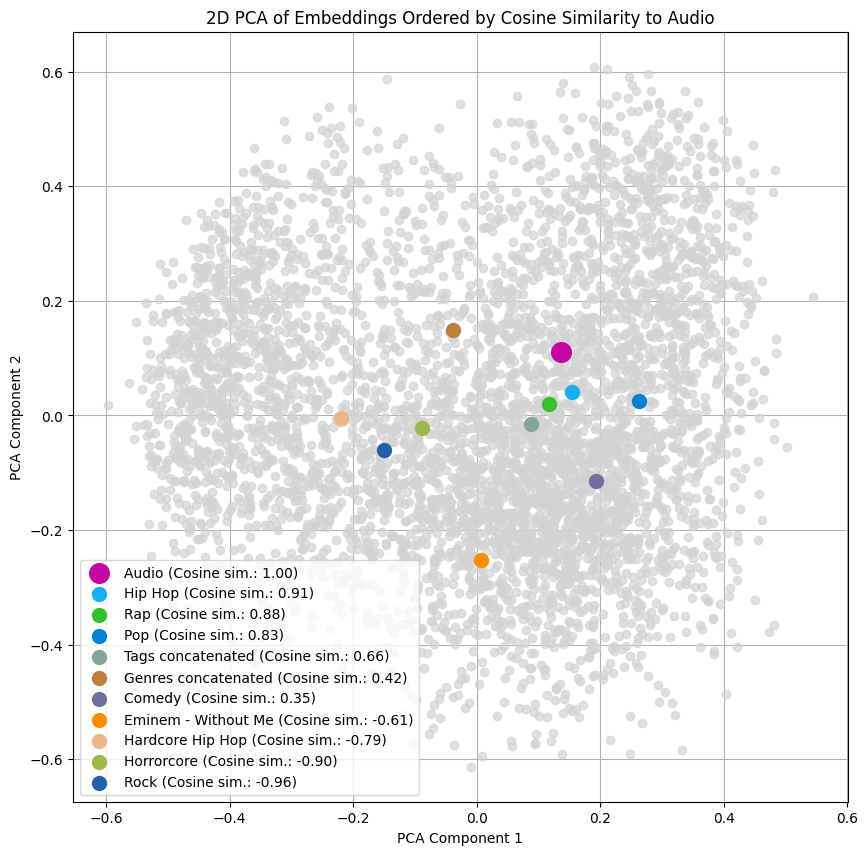

In [20]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.colors import ListedColormap

# Assuming `reduced_embeddings` is your array of embeddings
# Calculate cosine similarity with the 'Audio' embedding (index 0)
audio_embedding = reduced_embeddings[0].reshape(1, -1)
cosine_similarities = cosine_similarity(audio_embedding, reduced_embeddings).flatten()

# Get sorted indices based on cosine similarity (descending order)
sorted_indices = np.argsort(-cosine_similarities)

# Define the label names
label_names = [
    'Audio', 'Genres concatenated', 'Rap', 'Hip Hop', 'Pop', 'Horrorcore',
    'Hardcore Hip Hop', 'Rock', 'Comedy', 'Tags concatenated', 'Eminem - Without Me'
]

# Generate random distinct colors for the points
np.random.seed(10)  # Seed for reproducibility
random_colors = np.random.rand(len(label_names), 3)  # RGB values for each label

# Plot the embeddings in the order of cosine similarity
plt.figure(figsize=(10, 10))
for i, idx in enumerate(sorted_indices):
    if idx < len(label_names):  # Only process labeled indices
        color = 'darkorange' if idx == 10 else random_colors[idx]
        plt.scatter(
            reduced_embeddings[idx, 0], reduced_embeddings[idx, 1],
            label=f'{label_names[idx]} (Cosine sim.: {cosine_similarities[idx]:.2f})',
            color=color, zorder=3, s=200 if idx == 0 else 100
        )

# Plot remaining unlabelled points
plt.scatter(reduced_embeddings[11:, 0], reduced_embeddings[11:, 1], color='lightgrey', alpha=0.7, zorder=2)

# Add title and axis labels
plt.title("2D PCA of Embeddings Ordered by Cosine Similarity to Audio")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Add legend
plt.legend()
plt.grid()
plt.show()